# 10. Train an SVM regressor on the California housing dataset.    

## 1. PROBLEM DEFINITION

We want to predict the housing price in california given a CSV with features such as location, bedrooms, income, etc.

For that we will use a SVM regressor: SVR

## 2. DATA RECOLECTION

Data is loaded from a CSV given by the instructor.

## 3. EDA

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load dataset
filepath = "datasets/housing/housing.csv"

housing = pd.read_csv(filepath)

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
numeric_cols = list(housing.select_dtypes(float).columns)
cat_cols = list(housing.select_dtypes(object).columns)

print("Numeric columns: ", numeric_cols)
print("Categorical columns: ", cat_cols)

Numeric columns:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns:  ['ocean_proximity']


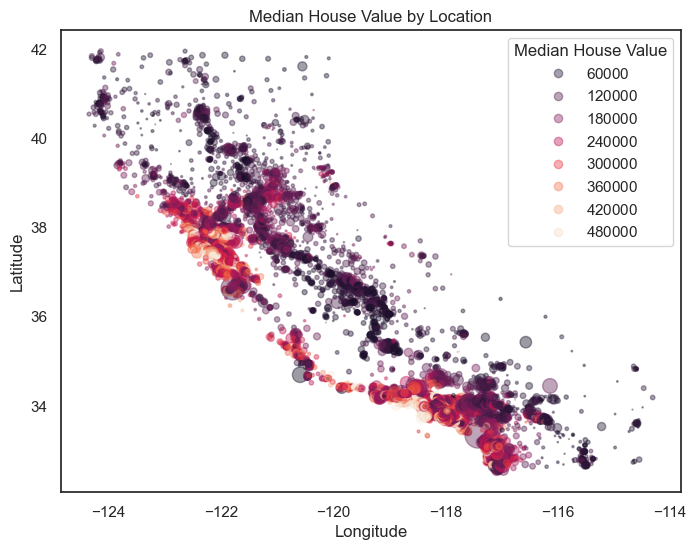

In [38]:
# X,Y are coordinates, color is median_house_income, size is population. Add legend, title, and axis labels.

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    housing['longitude'],
    housing['latitude'],
    c=housing['median_house_value'],
    s=housing['population']/100,
    alpha=0.4,
    cmap='rocket')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Median House Value by Location')
ax.legend(*scatter.legend_elements(), loc='upper right', title='Median House Value')
plt.show()


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

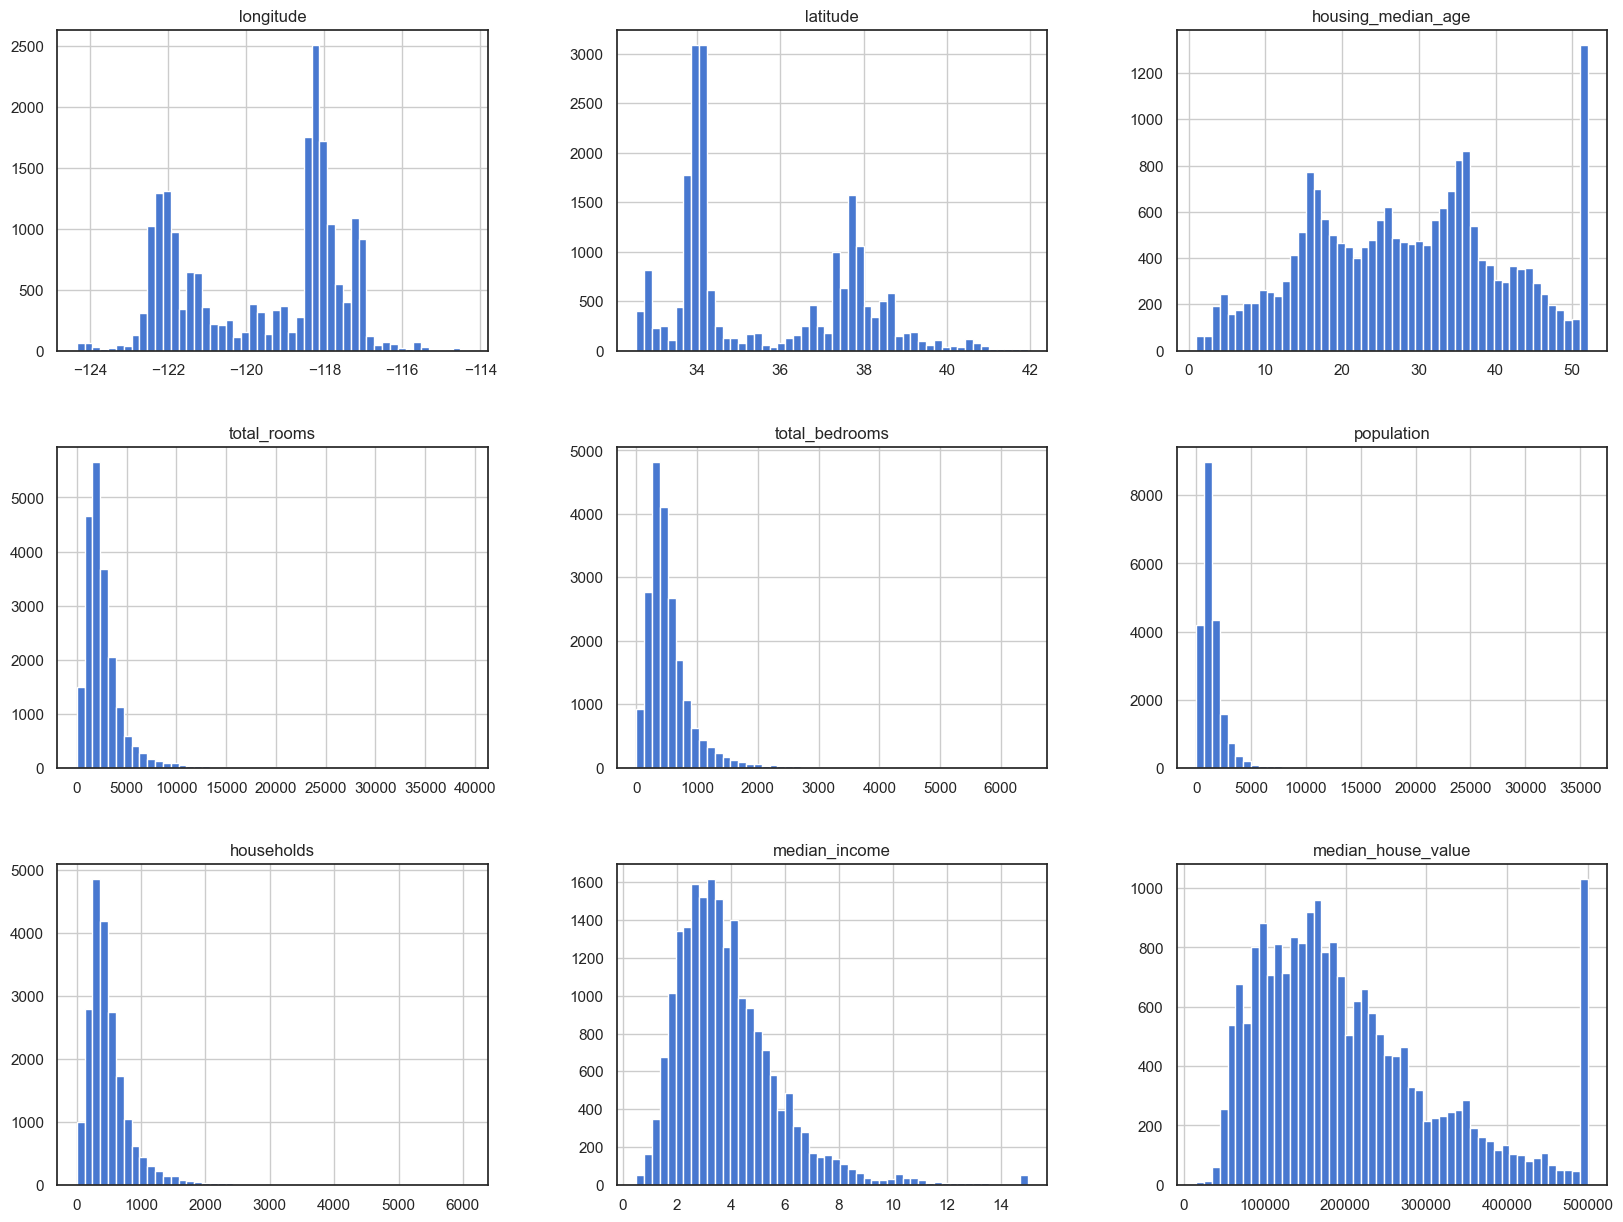

In [39]:
# Plot an histogram for every numeric feature
# The histogram is plotted for every class (median_house_value)

housing.hist(bins=50, figsize=(20,15))

## 4. TRAIN TEST SPLIT

Our target feature is housing_median_income. We saw that it is tail heavy, so we might want an stratified split.

In [41]:
# Select columns

target_feature = "median_house_value"
X = housing.drop(target_feature, axis=1)
y = housing[target_feature].copy()

In [44]:
# Stratified split by y which is continuous. It is median_house_value.

from sklearn.model_selection import StratifiedShuffleSplit

# Create a new column for stratified split

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Stratified split by income_cat
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

# Check the distribution of income_cat in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: count, dtype: float64

In [45]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [47]:
print(strat_train_set.shape)
print(strat_test_set.shape)

(16512, 10)
(4128, 10)


## 5. PREPROCESSING

Create preprocessing pipelines for:
1. NAs
2. STD scaling
3. Encoding